In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from PIL import Image
from agent import ML_Wrapper, CostSurface, PPOAgent, CustomTorchModel # custom ML classes

ImportError: cannot import name 'ML_Wrapper' from 'agent' (/home/ben/gym/grid/agent.py)

In [ ]:
# Load the pre-processed cost surfaces
cost_surface = CostSurface()
cost_surface.load_rasters('./cost_surfaces/10km_112nat_336reg_672loc/')

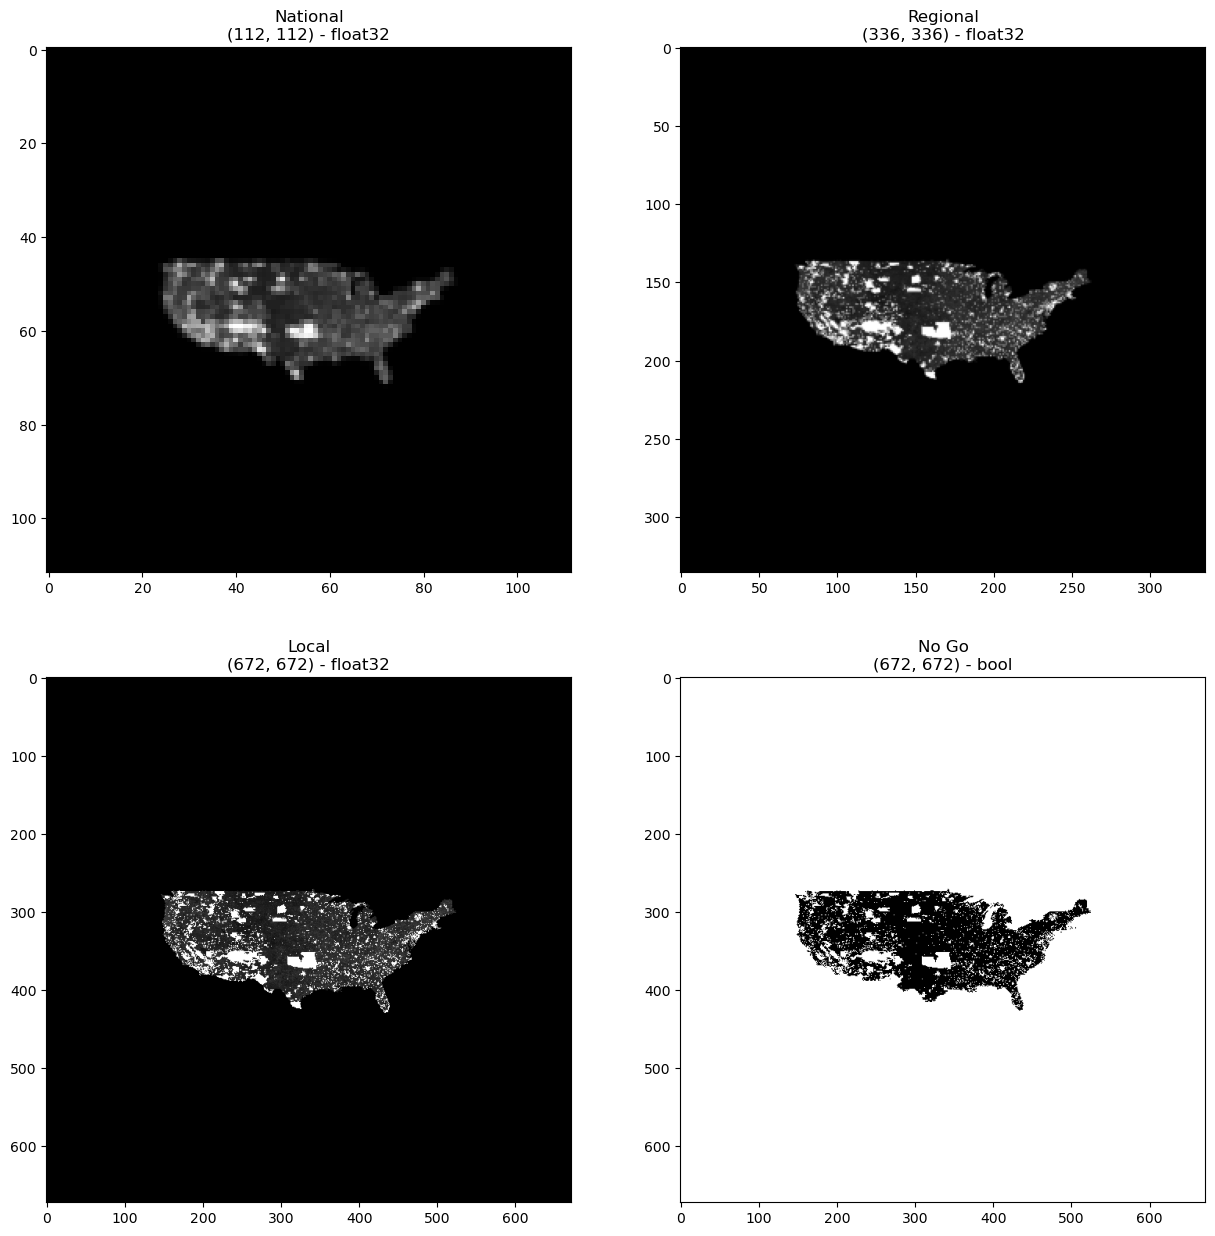

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

ax[0,0].set_title('National\n{} - {}'.format(cost_surface.national.shape, cost_surface.national.dtype))
ax[0,0].imshow(cost_surface.national, cmap='gray')

ax[0,1].imshow(cost_surface.regional, cmap='gray')
ax[0,1].set_title('Regional\n{} - {}'.format(cost_surface.regional.shape, cost_surface.regional.dtype))

ax[1,0].imshow(cost_surface.local, cmap='gray')
ax[1,0].set_title('Local\n{} - {}'.format(cost_surface.local.shape, cost_surface.local.dtype))

ax[1,1].imshow(cost_surface.no_go, cmap='gray')
ax[1,1].set_title('No Go\n{} - {}'.format(cost_surface.no_go.shape, cost_surface.no_go.dtype))

plt.show()

In [ ]:
def nomrmalize(arr, high=1, low=0):
    norm = (high-low)*(arr - arr.min())/(arr.max() - arr.min()) + low
    return norm

(400, 750)
1.0
0.0


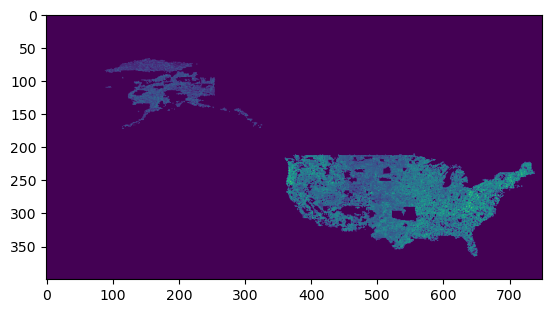

In [ ]:
# For comparison take a look at the original raster
img = Image.open('./cost_surfaces/10km_112nat_336reg_672loc/ras_10km_resampled_071323_WGS84_PIL.tif')
original = np.array(img)
clip = original[:400,:750]
clip[clip==np.inf] = 0
clip[clip==-1] = 0
norm = nomrmalize(clip)
print(norm.shape)
print(norm.max())
print(norm.min())
plt.imshow(norm[:400,:750])
plt.show()

In [ ]:
def generate_locations(no_go, start, target, rng, max_distance=50):
    """
    Can be used to generate valid start and target locations
    """

    while start is None:
        shape = no_go.shape
        y = rng.integers(0, shape[0], 1)[0]
        x = rng.integers(0, shape[1], 1)[0]
        if not no_go[y, x]:
            start = (y, x)
    
    while target is None:
        shape = no_go.shape
        y = rng.integers(
            max(0, start[0]-max_distance), 
            min(shape[0], start[0] + max_distance),
            1
        )
        y = y[0]

        x = rng.integers(
            max(0, start[1]-max_distance), 
            min(shape[1], start[1] + max_distance),
            1
        )
        x = x[0]

        if not no_go[y, x]:
            target = (y, x)

    return start, target

In [ ]:
rng = np.random.default_rng(seed=5)
start, target = generate_locations(cost_surface.no_go, start=None, target=None, rng=rng)

In [ ]:
# Convert from processed raster to orginal raster coordinates (Ben -> Lucy)
org_start = cost_surface.from_game_coordiantes(*start)
org_target = cost_surface.from_game_coordiantes(*target)


In [ ]:
print(start)
print(org_start)
print(target)
print(org_target)

(315, 346)
(254, 560)
(328, 324)
(267, 538)


In [ ]:
def draw_circle(img, start, target, radius):
    """
    Creates a three channel colored image with start and target locations.
    """
    r = img.copy()
    g = np.zeros(img.shape)
    b = np.zeros(img.shape)

    y, x = np.mgrid[:img.shape[0], :img.shape[1]]
    
    circle = (y-start[0])**2 + (x-start[1])**2
    b[circle < radius**2] = 1

    circle = (y-target[0])**2 + (x-target[1])**2
    g[circle < radius**2] = 1

    r = np.expand_dims(r, axis=2)
    g = np.expand_dims(g, axis=2)
    b = np.expand_dims(b, axis=2)

    new_img = np.concatenate((r,g,b), axis=2)


    return new_img

(400, 750, 3)
float64


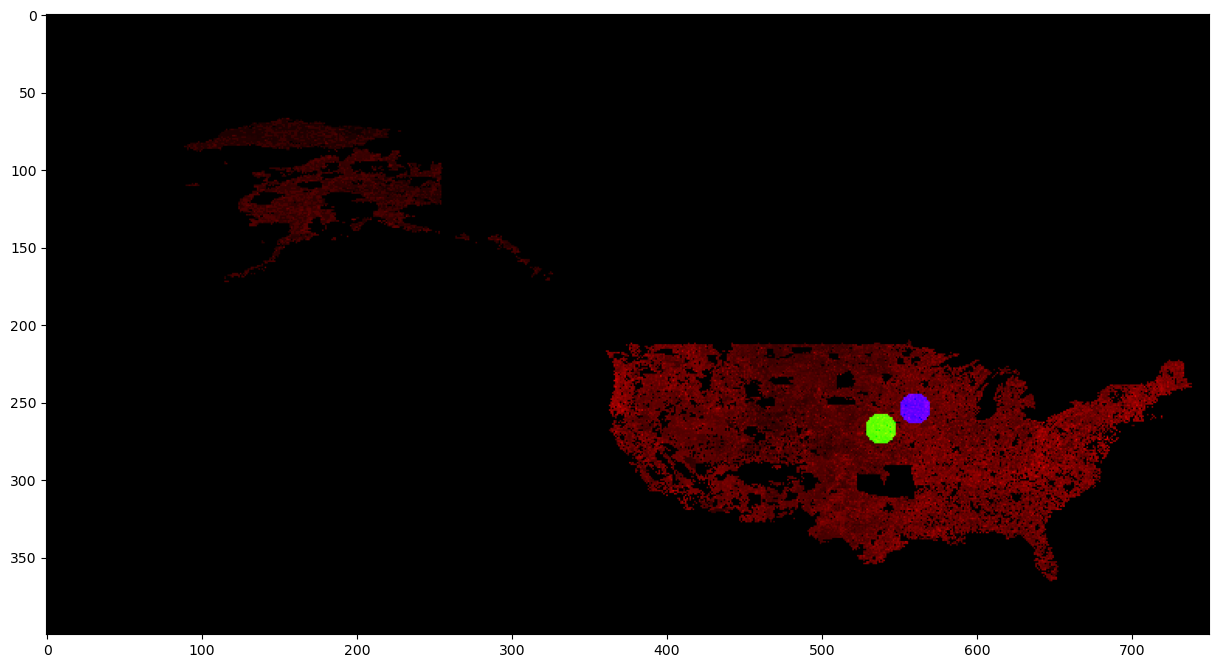

In [ ]:

org_raster = draw_circle(norm, org_start, org_target, radius=10)
print(org_raster.shape)
print(org_raster.dtype)
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(org_raster)
plt.show()

(672, 672, 3)
float64


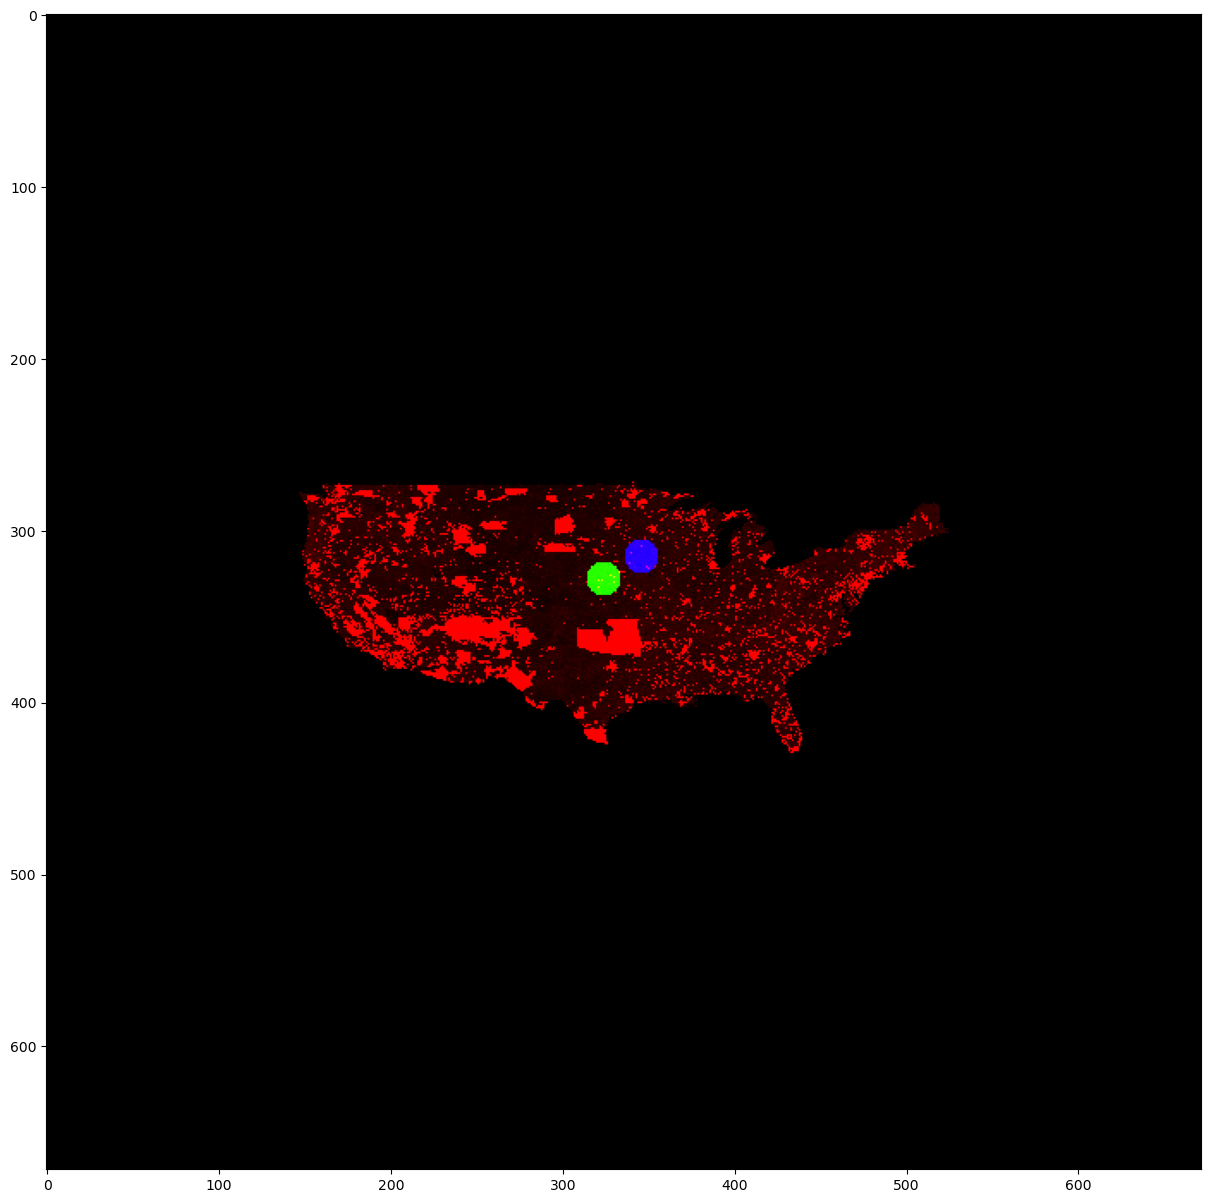

In [ ]:
processed_raster = cost_surface.local.copy()
processed_raster = draw_circle(cost_surface.local.copy(), start, target, 10)
print(processed_raster.shape)
print(processed_raster.dtype)
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(processed_raster)
plt.show()

In [ ]:
# Define agent which makes routing choices
agent = PPOAgent()
agent.load_model('./trained_model/model.pt')
observation_images = agent.route(
    cost_surface=cost_surface,
    start=start,
    target=target,
    return_images=True
    )

In [ ]:
fps=480
duration = 1000/fps # duration in ms
imageio.mimsave('./test-agent.gif', observation_images, duration=duration)  

In [ ]:
ml_wrapper = ML_Wrapper()
results = ml_wrapper.route(org_start, org_target)

In [ ]:
results['route']

[(254, 560),
 (255, 560),
 (256, 560),
 (257, 560),
 (258, 560),
 (259, 560),
 (260, 560),
 (261, 560),
 (262, 560),
 (263, 560),
 (264, 560),
 (263, 559),
 (264, 559),
 (263, 558),
 (264, 558),
 (263, 557),
 (262, 556),
 (261, 555),
 (262, 555),
 (261, 554),
 (262, 554),
 (263, 554),
 (264, 554),
 (263, 553),
 (262, 552),
 (263, 552),
 (264, 552),
 (263, 551),
 (262, 550),
 (263, 550),
 (264, 550),
 (263, 549),
 (262, 548),
 (263, 548),
 (264, 548),
 (263, 547)]